In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_prefix = '/content/drive/My Drive/NLP'
except ModuleNotFoundError:
    data_prefix = 'data'

In [6]:
raw_train = pd.read_parquet(os.path.join(data_prefix, 'train.parquet'))

In [7]:
raw_train.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


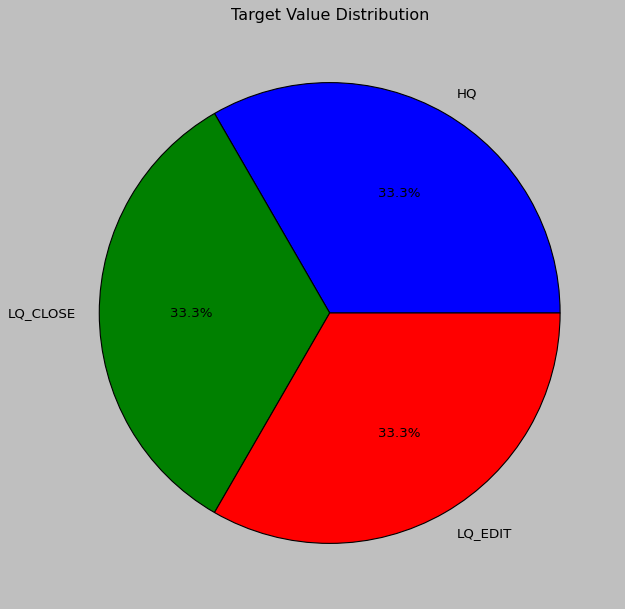

In [8]:
labels = ['HQ', 'LQ_CLOSE', 'LQ_EDIT']
values = [len(raw_train[raw_train['target'] == 0]),
          len(raw_train[raw_train['target'] == 1]),
          len(raw_train[raw_train['target'] == 2])]
plt.style.use('classic')
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

# Разделение данных на тренировочную и валидационную выборки 

В курсе по NLP от ШАДа рекомендуют делать это разделение до начала предварительной обработки, чтобы нигде не накосячить, поэтому мы тоже так сделаем.

In [9]:
raw_target = raw_train['target']
raw_data   = raw_train.drop(['target'], axis = 1)

In [10]:
raw_target.head()

Id
34862324    2
47303682    2
46431243    0
45306324    0
49479547    1
Name: target, dtype: int64

In [11]:
raw_data.head()

,Body,Tags,Title
Id,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,..."
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...


In [12]:
train_data, test_data, train_target, test_target = train_test_split(raw_data, raw_target,
                                                                    test_size=0.25, random_state=47)

In [13]:
print('Training Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape:  (36000, 3)
Test Data Shape:  (12000, 3)


In [14]:
[len(train_target[train_target == 0]),
 len(train_target[train_target == 1]),
 len(train_target[train_target == 2])]

[12029, 12032, 11939]

In [15]:
train_data.head()

,Body,Tags,Title
Id,,,
41452608,"df <- data.frame(id = c(1, 1, 2, 2, 2), desc =...",<r><dplyr>,R dplyr - count and select first row by group
39823020,<p>Can anyone tell what could be the solution ...,<java><android><ads>,AdMob ads in app not working on some devices
52003167,"<p>Let's say i have <code>a=[1,0,1,0,1,1,1,0,0...",<python><python-3.x>,How to remove more than one elements from list...
38850633,<p>I am new in ios development. I have created...,<ios><app-store>,App submission with coming soon alert
54208043,<p>I want to change the default colors (curren...,<r><ggplot2>,How to change default color of points in ggplo...


In [16]:
test_data.head()

,Body,Tags,Title
Id,,,
51918932,<p>the question can maybe be stupid but did no...,<laravel><npm><assets><node-modules><selectize...,How to properly include a library from node_mo...
46068744,I am porting unity game to universal windows p...,<c#><unity3d><uwp><visual-studio-2017><build-e...,Getting error in compiling Unity Universal Win...
36958873,I just did an upgrade from CRM 2011 to CRM 201...,<html><dynamics-crm-2015>,crm 2015 unsupported line of code - HTML Resource
57230064,"I have a list of items and for some purpose, I...",<android><android-fragments><android-recyclerv...,java.lang.IndexOutOfBoundsException: Invalid i...
51532513,******************** The html string is. *****...,<ios><swift><webview>,ios how to show htmlString into webview the ht...


# Предварительная обработка данных

In [18]:
import nltk
nltk.download('stopwords')

from data_preprocessing import remove_html_tags, stay_only_a_z, tokenize_by_word, remove_stop_words

[nltk_data] Downloading package stopwords to /home/droman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
'''
надо пересмотреть эту функцию


def clean_text(dataframe, field='text'):
    def clean_str(text): 
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]','', text)
        return text
  dataframe[field] = data[field].apply(clean_str)
  return dataframe

data = clean_text(data)'''

"\nнадо пересмотреть эту функцию\n\n\ndef clean_text(dataframe, field='text'):\n    def clean_str(text): \n        text = text.lower()\n        text = re.sub(r'[^(a-zA-Z)\\s]','', text)\n        return text\n  dataframe[field] = data[field].apply(clean_str)\n  return dataframe\n\ndata = clean_text(data)"

## Демонстрация работы препроцессингов

In [20]:
remove_html_tags('''
<p>I am using nltk. However, I've just got up to the method like</p>

<pre><code>my_text = ['This', 'is', 'my', 'text']
</code></pre>

<p>I'd like to discover any way to input my "text" as:</p>

<pre><code>my_text = "This is my text, this is a nice way to input text."
</code></pre>
''')

/home/droman/Documents/courses/nlp/data_preprocessing.py:13: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 13 of the file /home/droman/Documents/courses/nlp/data_preprocessing.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  return BeautifulSoup(html).get_text()


'\nI am using nltk. However, I\'ve just got up to the method like\nmy_text = [\'This\', \'is\', \'my\', \'text\']\n\nI\'d like to discover any way to input my "text" as:\nmy_text = "This is my text, this is a nice way to input text."\n\n'

In [21]:
stay_only_a_z("(A)lgorithmm:\r\n\r\n**input :** Graph G\r\n\r\n**output:** Set of MSTs T\r\n\r\n**begin*")

'Algorithmm\r\n\r\ninput  Graph G\r\n\r\noutput Set of MSTs T\r\n\r\nbegin'

In [22]:
tokenize_by_word("(A)lgorithmm:\r\n\r\n**input :** Graph G\r\n\r\n**output:** Set of MSTs T\r\n\r\n**begin*")

'( A ) lgorithmm : ** input :** Graph G ** output :** Set of MSTs T ** begin *'

In [23]:
remove_stop_words(
    tokenize_by_word('Algorithmm :  you\'d, your, yours, yourself, yourselves, he, him,   ** input :** '))

"Algorithmm : ' , , , , , , , ** input :**"

## Препроцессинг для Body

In [24]:
def body_preprocess(text):
#     text = remove_html_tags(text)
    text = stay_only_a_z(text)
    text = tokenize_by_word(text)
#     text = remove_stop_words(text)
    return text.lower()

In [25]:
body_preprocess('''
Algorithmm:

**input :** Graph G

**output:** Set of MSTs T

**begin**

T=null;
E=G.Edges;

for all vertices in G,
Create a tree t having single vertex b

add t to T

end for

     repeat
        Find an edge e ∈ E having minimum weight
        such that one end belongs to t ∈ T and the other
        end does not belongs to any of the trees in T
        Add e to t
      until e = NULL

I'm stuck on the logic for the highlighted block.
I've used simple objects for vertex,edge and tree. And for their sets, used array of Objects.''')

'algorithmm input graph g output set of msts t begin tnull egedges for all vertices in g create a tree t having single vertex b add t to t end for repeat find an edge e e having minimum weight such that one end belongs to t t and the other end does not belongs to any of the trees in t add e to t until e null im stuck on the logic for the highlighted block ive used simple objects for vertexedge and tree and for their sets used array of objects'

### Выполним препроцессинг для данных

In [26]:
train_data['Body'] = train_data['Body'].apply(body_preprocess)
test_data ['Body'] = test_data ['Body'].apply(body_preprocess)

<ipython-input-26-da182aa111b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Body'] = train_data['Body'].apply(body_preprocess)
<ipython-input-26-da182aa111b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data ['Body'] = test_data ['Body'].apply(body_preprocess)


In [27]:
train_data.head()

,Body,Tags,Title
Id,,,
41452608,df dataframeid c desc ca a b b b i would like ...,<r><dplyr>,R dplyr - count and select first row by group
39823020,pcan anyone tell what could be the solution of...,<java><android><ads>,AdMob ads in app not working on some devices
52003167,plets say i have codeacodep p i want to remove...,<python><python-3.x>,How to remove more than one elements from list...
38850633,pi am new in ios development i have created on...,<ios><app-store>,App submission with coming soon alert
54208043,pi want to change the default colors currently...,<r><ggplot2>,How to change default color of points in ggplo...


## Препроцессинг для Title

In [28]:
def title_preprocessing(text):
    text = stay_only_a_z(text)
    text = tokenize_by_word(text)
    return text.lower()

In [29]:
train_data['Title'] = train_data['Title'].apply(title_preprocessing)
test_data ['Title'] = test_data ['Title'].apply(title_preprocessing)

<ipython-input-29-e5c6a9bb7a00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Title'] = train_data['Title'].apply(title_preprocessing)
<ipython-input-29-e5c6a9bb7a00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data ['Title'] = test_data ['Title'].apply(title_preprocessing)


In [30]:
train_data.head()

,Body,Tags,Title
Id,,,
41452608,df dataframeid c desc ca a b b b i would like ...,<r><dplyr>,r dplyr count and select first row by group
39823020,pcan anyone tell what could be the solution of...,<java><android><ads>,admob ads in app not working on some devices
52003167,plets say i have codeacodep p i want to remove...,<python><python-3.x>,how to remove more than one elements from list...
38850633,pi am new in ios development i have created on...,<ios><app-store>,app submission with coming soon alert
54208043,pi want to change the default colors currently...,<r><ggplot2>,how to change default color of points in ggplo...


# Секция для определения исходных фичей

In [31]:
def get_raw_features(__data):
    __data['text'] = __data['Title'] + ' ' + __data['Body']
    return __data.drop(['Tags', 'Title', 'Body'], axis=1)

In [32]:
train_data = get_raw_features(train_data)
test_data = get_raw_features(test_data)

<ipython-input-31-e70b16de7c75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  __data['text'] = __data['Title'] + ' ' + __data['Body']


In [33]:
train_data.head()

,text
Id,
41452608,r dplyr count and select first row by group df...
39823020,admob ads in app not working on some devices p...
52003167,how to remove more than one elements from list...
38850633,app submission with coming soon alert pi am ne...
54208043,how to change default color of points in ggplo...


In [34]:
test_data.head()

,text
Id,
51918932,how to properly include a library from nodemod...
46068744,getting error in compiling unity universal win...
36958873,crm unsupported line of code html resource i j...
57230064,javalangindexoutofboundsexception invalid inde...
51532513,ios how to show htmlstring into webview the ht...


# Не забыть уйти от Pandas

In [35]:
train_data = train_data['text']
test_data = test_data['text']

train_target = train_target.values
test_target  = test_target.values

# Векторизация данных

## 1. BOW (Bag of words)

In [38]:
def bow(train, test):
    bow_vectorizer = CountVectorizer()
    train_vec = bow_vectorizer.fit_transform(train)
    test_vec = bow_vectorizer.transform(test)
    return train_vec, test_vec

## 2. tf-idf

In [39]:
def tf_idf(train, test):
    tfidf_vectorizer = TfidfVectorizer()
    train_vec = tfidf_vectorizer.fit_transform(train)
    test_vec = tfidf_vectorizer.transform(test)

    return train_vec, test_vec

## W2V

In [21]:
import gensim.downloader as api
word2vec_model300 = api.load('word2vec-google-news-300')
word2vec_model300['upload']

array([-0.08251953, -0.03393555, -0.05200195,  0.08691406,  0.04663086,
        0.10205078,  0.11523438,  0.14941406,  0.07617188, -0.02319336,
       -0.28515625,  0.06298828, -0.06591797,  0.08105469, -0.18261719,
        0.34765625,  0.25390625,  0.21386719, -0.03833008, -0.20800781,
       -0.01513672,  0.05859375, -0.31054688,  0.3125    , -0.046875  ,
       -0.21386719,  0.09960938, -0.140625  ,  0.13964844, -0.31445312,
       -0.25      , -0.00430298, -0.02282715, -0.15625   , -0.19921875,
       -0.33398438,  0.00476074, -0.20996094,  0.18164062,  0.16015625,
       -0.11425781,  0.23535156,  0.31445312,  0.15722656,  0.01086426,
       -0.2890625 , -0.08105469,  0.12988281,  0.0213623 , -0.0625    ,
       -0.17871094, -0.30859375,  0.26953125, -0.16308594, -0.00300598,
       -0.01782227, -0.05444336,  0.05200195, -0.20507812,  0.31445312,
        0.48828125, -0.16601562, -0.23828125, -0.16992188, -0.1484375 ,
        0.05541992, -0.19140625,  0.00189209,  0.26171875,  0.34

In [48]:
w2v_test_str = 'algorithmm input graph g output set of msts t begin tnull egedges for all vertices in g create a tree t having single vertex b add t to t end for repeat find an edge e e having minimum weight such that one end belongs to t t and the other end does not belongs to any of the trees in t add e to t until e null im stuck on the logic for the highlighted block ive used simple objects for vertexedge and tree and for their sets used array of objects'

In [40]:
def get_w2v_str_representation_mean(text, model):
    words = text.split()
    words_representation = [model[word] for word in words if word in model.vocab]
    return np.mean(words_representation, axis=0)

def get_w2v_str_representation_sum(text, model):
    words = text.split()
    words_representation = [model[word] for word in words if word in model.vocab]
    return np.sum(words_representation, axis=0)

In [ ]:
# !curl https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1 

In [46]:
from gensim.models.keyedvectors import KeyedVectors
so_w2v = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

In [61]:
get_w2v_str_representation_sum(w2v_test_str, so_w2v)[:10]

array([  8.154484,  12.033579, -41.343773,  38.206593, -77.40206 ,
        46.77203 ,  28.464117,  15.215707, -20.109539,  -9.964755],
      dtype=float32)

In [41]:
def w2v_vectorizer_sum_news(train, test):
    return ([get_w2v_str_representation_sum(text, word2vec_model300) for text in train],
            [get_w2v_str_representation_sum(text, word2vec_model300) for text in test])

def w2v_vectorizer_mean_news(train, test):
    return ([get_w2v_str_representation_mean(text, word2vec_model300) for text in train],
            [get_w2v_str_representation_mean(text, word2vec_model300) for text in test])

def w2v_vectorizer_sum_so(train, test):
    return ([get_w2v_str_representation_sum(text, so_w2v) for text in train],
            [get_w2v_str_representation_sum(text, so_w2v) for text in test])

def w2v_vectorizer_mean_so(train, test):
    return ([get_w2v_str_representation_mean(text, so_w2v) for text in train],
            [get_w2v_str_representation_mean(text, so_w2v) for text in test])

# D2V

In [45]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("./d2v/doc2vec.bin")


In [60]:

def d2v_vectorizer(train, test):
    return ([model.infer_vector([text]) for text in train],
            [model.infer_vector([text]) for text in test])

# Построение классификаторов


## 1. kNN

In [54]:
def knn_score(trainX, trainY, testX, testY):
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(trainX, trainY)
    return knn_classifier.score(testX, testY)

## 2. Random Forests

In [55]:
def random_forest_score(trainX, trainY, testX, testY):
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(trainX, trainY)
    return rf_classifier.score(testX, testY)

## 3. Логистическая регрессия

In [56]:
def lr_score(trainX, trainY, testX, testY):
    lr_classifier = LogisticRegression()
    lr_classifier.fit(trainX, trainY)
    return lr_classifier.score(testX, testY)

In [57]:
'''========================================================================================================================
========================================================================================================================
========================================================================================================================
'''

'========================================================================================================================\n========================================================================================================================\n========================================================================================================================\n'

In [58]:
def visualize_results(score):
    print(score)

def base_pipeline(train_x, train_y, test_x, test_y,
                  vectorizer, scorer):
    vectorized_train_x, vectorized_test_x = vectorizer(train_x, test_x)
    score = scorer(vectorized_train_x, train_y, vectorized_test_x, test_y)
    visualize_results(score)

In [40]:
# 1 attempt: basic cleaner, bow, knn 
# base_pipeline(train_data, train_target, test_data, test_target,
#               bow, random_forest_score)

In [41]:
base_pipeline(train_data, train_target, test_data, test_target,
              bow, lr_score)

0.8834166666666666


/home/agladyshev/anaconda3/envs/unn-nlp/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [65]:
base_pipeline(train_data, train_target, test_data, test_target,
              tf_idf, lr_score)

0.8795


/home/daniil/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
base_pipeline(train_data, train_target, test_data, test_target,
              w2v_vectorizer_sum_so, lr_score)

0.7144166666666667


/home/daniil/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
base_pipeline(train_data, train_target, test_data, test_target,
              w2v_vectorizer_mean_news, lr_score)

/home/daniil/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7126666666666667


In [61]:
base_pipeline(train_data, train_target, test_data, test_target,
              d2v_vectorizer, lr_score)

/home/droman/Documents/diploma/venv/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "
/home/droman/Documents/diploma/venv/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:467: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  warnings.warn("Default multi_class will be changed to 'auto' in"


0.3278333333333333
